# Project Orange: IMDB reviews sentiment analysis

## Setup

Install all required dependencies in the current Jupyter kernel

In [146]:
import sys
!{sys.executable} -m pip install spacy pandas sklearn
!{sys.executable} -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [147]:
import pandas as pd
import re
import spacy
from spacy import displacy
from spacy.lang.en import English
from sklearn.model_selection import train_test_split

sp = spacy.load('en_core_web_sm')

### Import dataset

In [148]:
# Read data from file 'filename.csv' 
# (in the same directory that your python process is based)
# Control delimiters, rows, column names with read_csv (see later) 
data = pd.read_csv("../data/IMDB Dataset.csv") 

# Keep the first 10 elements to reduce the load on cpu
data=data[:10]
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [149]:
#base rate, delete later
a=data[data["sentiment"]=="positive"].shape
b=data[data["sentiment"]=="negative"].shape
base_rate=max(a[0], b[0])/data.shape[0]
print("The base rate is "+ str(base_rate))

The base rate is 0.7


### Text to lowercase

In [150]:
def to_lower(this_review):
    this_review=this_review.lower()
    return this_review
    
data['review'] = data['review'].map(to_lower)
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive


### Remove HTML elements

In [151]:
REMOVE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def remove_html(review):
    return REMOVE_HTML.sub("", review) 

data['cleaned_review'] = data['review'].map(remove_html)
data.head()

,review,sentiment,cleaned_review
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is..."


### Identify and remove entities

In [152]:
def recognize_it(this_review):
    doc=sp(this_review)
    
    for i in doc.ents:
            i=str(i)
            this_review=this_review.replace(" "+i,"")
    return this_review

In [153]:
data['IDcleaned_review'] = data['cleaned_review'].map(recognize_it)
data.head()

,review,sentiment,cleaned_review,IDcleaned_review
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,a wonderful little production. the filming tec...
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's a family where a little boy ...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter's ""love in the time of money"" is a visu..."


### Lemmatization

In [154]:
# Implementing lemmatization
def lemmatize_it(this_review):
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    lem = sp(this_review)
    
   # finding lemma for each word
    for word in lem:
        filtered_sent.append(word.lemma_)
    return filtered_sent

In [155]:
data['lemmatized_review'] = data['IDcleaned_review'].map(lemmatize_it)
data.head()

,review,sentiment,cleaned_review,IDcleaned_review,lemmatized_review
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewer, have, mention,..."
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, think, this, be, a, wonderful, way, to, sp..."
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's a family where a little boy ...,"[basically, there, be, a, family, where, a, li..."
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter's ""love in the time of money"" is a visu...","[petter, 's, "", love, in, the, time, of, money..."


### Tokenization (not used)

In [156]:
# "nlp" Object is used to create documents with linguistic annotations.
nlp = English()

def tokenize_review(this_review):
    my_doc = nlp(this_review)
    
    # Create list of word tokens
    token_list = []
    for token in my_doc:
        token_list.append(token.text)
    return token_list

In [157]:
#data['tokenized_review'] = data['cleaned_review'].map(tokenize_review)
#data.head()

### Adapt spacy stopwords list to our topic

In [158]:
#print stopword list from spacy
spacy_stopwords = list(spacy.lang.en.stop_words.STOP_WORDS)

remove_from_stopwordlist=["n't", "most", "much", "never", "no", "not", "nothing", "n‘t", "n’t", "really", "top", "very", "well"]
for word in spacy_stopwords:
    if word in remove_from_stopwordlist:
         spacy_stopwords.remove(word)

add_to_stopwords=['.', ',', '!', '?', ':', '&', '...', '(', ')','-', '/', '"', ';']
for word in add_to_stopwords:
    spacy_stopwords.append(word)

###  Remove stopwords and punctuation

In [159]:
def eliminate_stopwords(this_review):
    
    filtered_sent=[]

    #  "nlp" Object is used to create documents with linguistic annotations.
    doc = this_review
    
    # filtering stop words
    for word in doc:
        if word not in spacy_stopwords:
            filtered_sent.append(word)
    return filtered_sent
    

In [160]:
data['stopcleaned_review'] = data['lemmatized_review'].map(eliminate_stopwords)
data.head()

,review,sentiment,cleaned_review,IDcleaned_review,lemmatized_review,stopcleaned_review
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewer, have, mention,...","[reviewer, mention, watch, oz, episode, -PRON-..."
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil...","[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, think, this, be, a, wonderful, way, to, sp...","[think, wonderful, way, spend, time, hot, sit,..."
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's a family where a little boy ...,"[basically, there, be, a, family, where, a, li...","[basically, family, little, boy, jake, think, ..."
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter's ""love in the time of money"" is a visu...","[petter, 's, "", love, in, the, time, of, money...","[petter, love, time, money, visually, stunning..."


Do we do Bag of Words?
Do we do TF-IDF?

In [161]:
def MASTA_CLEAN(this_review):
    this_review=to_lower(this_review)
    this_review=remove_html(this_review)
    this_review=recognize_it(this_review)
    this_review=lemmatize_it(this_review)
    this_review=eliminate_stopwords(this_review)
    return this_review

In [162]:
data['mastacleaned_reviews'] = data['review'].map(MASTA_CLEAN)
data.head()

,review,sentiment,cleaned_review,IDcleaned_review,lemmatized_review,stopcleaned_review,mastacleaned_reviews
0,one of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,"[one, of, the, other, reviewer, have, mention,...","[reviewer, mention, watch, oz, episode, -PRON-...","[reviewer, mention, watch, oz, episode, -PRON-..."
1,a wonderful little production. <br /><br />the...,positive,a wonderful little production. the filming tec...,a wonderful little production. the filming tec...,"[a, wonderful, little, production, ., the, fil...","[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,"[i, think, this, be, a, wonderful, way, to, sp...","[think, wonderful, way, spend, time, hot, sit,...","[think, wonderful, way, spend, time, hot, sit,..."
3,basically there's a family where a little boy ...,negative,basically there's a family where a little boy ...,basically there's a family where a little boy ...,"[basically, there, be, a, family, where, a, li...","[basically, family, little, boy, jake, think, ...","[basically, family, little, boy, jake, think, ..."
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love in the time of money"" is...","petter's ""love in the time of money"" is a visu...","[petter, 's, "", love, in, the, time, of, money...","[petter, love, time, money, visually, stunning...","[petter, love, time, money, visually, stunning..."


### Splitting the dataset into training and test sets

In [182]:
X = data['review'] # the features we want to analyze, we can play with others too
y = data['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=72)

#### Logistic Model

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
classifier = LogisticRegression(solver="lbfgs")

tfidf_vector = TfidfVectorizer(tokenizer = MASTA_CLEAN)

# Create pipeline using Bag of Words
pipe = Pipeline([('vectorizer', tfidf_vector), ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...,
                                 tokenizer=<function MASTA_CLEAN at 0x000001AC39D9BF78>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_i

#### Evaluating Logistic Regression

In [190]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print(" train Accuracy:",pipe.score(X_train, y_train))
print(" test Accuracy:",metrics.accuracy_score(y_test, predicted))
print(" Precision:",metrics.precision_score(y_test, predicted, average=None))
print(" Recall:",metrics.recall_score(y_test, predicted, average=None))

#completer

 train Accuracy: 0.75
 test Accuracy: 1.0
 Precision: [1.]
 Recall: [1.]


Confusion matrix, without normalization


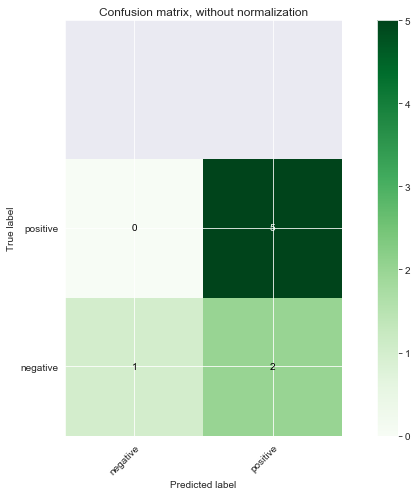

In [185]:
# confusion matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
from sklearn.metrics import confusion_matrix
log_reg = pipe
log_reg.fit(X_train,y_train)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Greens):
   
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(10,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.ylim([-0.5, 2.5])
    
    ax.xaxis.set_ticklabels(["negative", "positive"])
    ax.yaxis.set_ticklabels(["negative", "positive"])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout();
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_train, log_reg.predict(X_train), classes=data.sentiment,
                      title='Confusion matrix, without normalization')

### Text similarity

In [172]:
from sklearn.feature_extraction.text import CountVectorizer

stopwords = spacy_stopwords

# using default tokenizer 
count = CountVectorizer(ngram_range=(1,2), stop_words = None)
bow = count.fit_transform(data)

### Decision Trees

In [166]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

In [167]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [168]:
clf = DecisionTreeClassifier(criterion='entropy')

In [169]:
clf.fit(X_train, y_train)

ValueError: could not convert string to float: 'a wonderful little production. <br /><br />the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great master\'s of comedy and his life. <br /><br />the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwell\'s murals decorating every surface) are terribly well done.'

In [ ]:
clf.score(X_test,y_test)

In [ ]:
clf.get_depth()

#### Tuning the depth of the tree

In [ ]:
scores = []
for d in range(1, 21):
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d)
    clf.fit(X_train, y_train)
    scores.append(clf.score(X_test, y_test))

In [ ]:
plt.plot(scores)
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('depth', fontsize=15)

In [ ]:
np.argmax(scores)

 We need to have: 
* Precision & Recall for all methods 
* Precision-Recall curve 
* Cross-validation for all methods 


### KNN Classification

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [ ]:
np.random.seed = 72

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform') #here we can change the K-neighbors

In [ ]:
W = data['mastacleaned_reviews']
z = data['sentiment']
print(W.shape, z.shape)

In [ ]:
from sklearn.model_selection import train_test_split
W_train, W_test, z_train, z_test = train_test_split(W, z, test_size=0.2, random_state=10)

In [ ]:
#knn.fit(W_train, z_train) problem

In [ ]:
#knn.score(X_test, y_test)